# Feature Engineering

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Importing Data

In [34]:
def read_data(path: str) -> pd.DataFrame:
    df_train = pd.read_feather(os.path.join(path, 'train_combined.feather'))
    df_test = pd.read_feather(os.path.join(path, 'test_combined.feather'))

    return df_train, df_test

In [35]:
df_train, df_test = read_data('../data')

## Eliminating missing cols

In [36]:
def top_missing_cols(df: pd.DataFrame, thersh: int=80) -> list:
    dff = (df.isnull().sum() / df.shape[0]) * 100
    dff.columns = ['col_name', 'missing_percent']
    dff.sort_values(ascending=False, inplace=True)
    dff = dff[dff > thersh]
    return list(dff.keys())

In [37]:
def remove_top_missing_cols(df: pd.DataFrame, thersh: int=80) -> list:
    top_missing_cols_name = top_missing_cols(df, thersh=90)
    dff = df.copy()
    dff = dff.drop(columns=top_missing_cols_name)
    return dff

## Adding hour_of_day and day_of_week features

In [38]:
def  adding_time_features(df: pd.DataFrame) -> pd.DataFrame:
    dff = df.copy()
    dff['day_of_week'] = (df_train['TransactionDT']//(60*60*24)-1)%7
    dff['hour_of_day'] = (df_train['TransactionDT']//(60*60))%24
    return dff

In [39]:
time_features = ['day_of_week', 'hour_of_day']

## Eliminating correlated columns

In [40]:
def numerical_cols(df: pd.DataFrame) -> list:
    l = list(df.select_dtypes(include='number'))
    return l

In [41]:
def get_cols_eliminate(df: pd.DataFrame, thresh: float = 0.90) -> list:
    dff = df.copy()
    dff = dff[numerical_cols(dff)]
    if 'isFraud' in dff.columns:
        dff = dff.drop(columns=['isFraud'])
    if 'TransactionDT' in dff.columns:
        dff = dff.drop(columns=['TransactionDT'])
    corr_mat = dff.corr().abs()
    upper_tri = corr_mat.where(np.triu(np.ones(corr_mat.shape),k=1).astype(bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > thresh)]
    return to_drop

In [42]:
def eliminate_corr_cols(df: pd.DataFrame, thresh: float = 0.90) -> pd.DataFrame:
    cols = get_cols_eliminate(df, thresh)
    dff = df.copy()
    dff = dff.drop(columns=cols)
    return dff

## Eliminating Outliers

In [43]:
def eliminate_outliers(df: pd.DataFrame) -> pd.DataFrame:
    dff = df.copy()
    if not 'TransactionAmt' in dff.columns:
        return dff
    
    dff = dff[dff.TransactionAmt < 30000]
    dff = dff.reset_index()

    return dff

## Adding uid feature from card1 D1 and addr1

In [44]:
def add_uid(df: pd.DataFrame) -> pd.DataFrame:
    dff = df.copy()
    if not ('card1', 'D1', 'addr1' in dff.columns):
        print('Missing columns')
        return dff
    
    dff['uid'] = dff['card1'].astype(str) + '_' + dff['D1'].astype(str) + '_' + dff['addr1'].astype(str)

    return dff

## Pipeline

In [45]:
def pipeline(df: pd.DataFrame) -> pd.DataFrame:
    dff = df.copy()
    dff = add_uid(dff)
    dff = eliminate_outliers(dff)
    dff = eliminate_corr_cols(dff, 0.9)
    dff = remove_top_missing_cols(dff, 90)
    dff = adding_time_features(dff)
    return dff

In [46]:
dff = df_train.copy()
dff = pipeline(dff)

In [47]:
dff.head()

,index,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,uid,day_of_week,hour_of_day
0,0,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,None,None,None,None,None,None,None,13926_14.0_315.0,0,0
1,1,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,None,None,None,None,None,None,None,2755_0.0_325.0,0,0
2,2,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,None,None,None,None,None,None,None,4663_0.0_330.0,0,0
3,3,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,None,None,None,None,None,None,None,18132_112.0_476.0,0,0
4,4,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,4497_0.0_420.0,0,0


In [48]:
dff.info

<bound method DataFrame.info of          index  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0            0        0          86400           68.50         W  13926   
1            1        0          86401           29.00         W   2755   
2            2        0          86469           59.00         W   4663   
3            3        0          86499           50.00         W  18132   
4            4        0          86506           50.00         H   4497   
...        ...      ...            ...             ...       ...    ...   
590533  590535        0       15811047           49.00         W   6550   
590534  590536        0       15811049           39.50         W  10444   
590535  590537        0       15811079           30.95         W  12037   
590536  590538        0       15811088          117.00         W   7826   
590537  590539        0       15811131          279.95         W  15066   

        card2  card3       card4  card5  ...           id_34  id_35

# Evaluating

## Selecting split data

In [49]:
def train_test_split(df: pd.DataFrame, ratio: float=0.8, eq_fraudulent: bool = False, fraudulent_multiplier: float = 5) -> pd.DataFrame:
    dff = df.copy()
    # dff = dff.sort_values(by='TransactionDT')

    idx_train = dff.index[:int(dff.shape[0] * ratio)]
    idx_test = dff.index[int(dff.shape[0] * ratio):]

    df_train = dff.iloc[idx_train]
    df_test = dff.iloc[idx_test]

    if eq_fraudulent == True:
        df_train_fraud = df_train[df_train['isFraud'] == 1]
        df_train_fraud = pd.concat([df_train_fraud] * fraudulent_multiplier)
        df_train = pd.concat([df_train, df_train_fraud])
        df_train.reset_index()
        

    y_train = df_train['isFraud']
    x_train = df_train.drop(columns=['isFraud'])

    y_test = df_test['isFraud']
    x_test = df_test.drop(columns=['isFraud'])

    return x_train, y_train, x_test, y_test



In [50]:
# x_train, y_train, _, _ = train_test_split(df_train, 0.75, eq_fraudulent=True, fraudulent_multiplier=10)

In [51]:
# x_train.info

In [52]:
# sns.displot(data=y_train)
# plt.show()

## Training and evaluating models

### Logistic Pipeline

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [54]:
def numerical_cols(df: pd.DataFrame) -> list:
    l = list(df.select_dtypes(include='number'))
    # if 'isFraud' in l:
    #     l.remove('isFraud')
    return l

In [55]:
def inf_to_nan(df: pd.DataFrame) -> pd.DataFrame:
    return df.replace([np.inf, -np.inf], np.nan)

In [56]:
def fill_numerical_cols_and_scale(df: pd.DataFrame, exclude: list = []) -> pd.DataFrame:
    cols = numerical_cols(df)
    if 'isFraud' in cols:
        cols.remove('isFraud')
    
    for col in exclude:
        if col in cols:
            cols.remove(col)

    dff = df.copy()
    dff[cols] = inf_to_nan(dff[cols])

    imputer = SimpleImputer(strategy='median')
    dff[cols] = imputer.fit_transform(dff[cols])

    scaler = StandardScaler()
    dff[cols] = scaler.fit_transform(dff[cols])

    return dff

In [57]:
def label_encoding(df: pd.DataFrame, include: list = []) -> pd.DataFrame:
    cols = (['ProductCD'] + 
            ['card%d' % i for i in range(1, 7)] + 
            ['addr1', 'addr2', 'P_emaildomain', 'R_emaildomain'] + 
            ['DeviceType', 'DeviceInfo'] +
            ['M%d' % i for i in range(1, 10)] + 
            ['id_%d' % i for i in range(12, 39)] +
            include)
    
    dff = df.copy()
    for col in cols:
        if col in dff.columns:
            dff[col] = dff[col].astype('object')
            dff[col] = dff[col].fillna('MISSING')

            lb = LabelEncoder()
            lb.fit(list(dff[col].values))
            dff[col] = lb.transform(list(dff[col].values))

            # dff[col] = dff[col].astype('category')
    
    return dff

In [58]:
def logistic_pipeline(df: pd.DataFrame, exclude_numerical: list = [], include_categorical: list = []) -> pd.DataFrame:
    dff = df.copy()

    if 'TransactionDT' in dff.columns:
        dff = dff.sort_values(by='TransactionDT')
        dff = dff.drop(columns=['TransactionDT'])
    if 'TransactionID' in dff.columns:
        dff = dff.drop(columns=['TransactionID'])

    dff = inf_to_nan(dff)
    dff = fill_numerical_cols_and_scale(dff, exclude=exclude_numerical)
    dff = label_encoding(dff, include=include_categorical)

    return dff

In [59]:
dff = logistic_pipeline(dff, exclude_numerical=time_features, include_categorical=time_features + ['uid'])

In [60]:
x_train, y_train, x_test, y_test = train_test_split(dff, 0.75)

In [61]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590538 entries, 0 to 590537
Columns: 230 entries, index to hour_of_day
dtypes: float64(185), int32(30), int64(15)
memory usage: 973.2 MB


### XGBoost

In [62]:
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import RandomizedSearchCV

In [63]:
def xg_boost(x_train: pd.DataFrame, y_train: pd.Series, x_test: pd.DataFrame, y_test: pd.Series):
    clf = xgb.XGBClassifier( 
        missing=-1, learning_rate=0.02,
        eval_metric='auc', tree_method='gpu_hist',colsample_bytree=0.4,max_depth=12,n_estimators=2000,
        subsample=0.8, early_stopping_rounds=100, gpu_id=1)

    # d_train = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    #     d_validation = xgb.DMatrix(
    #         X_validation, label=y_validation, enable_categorical=True
    #     )


    model = clf.fit(x_train, y_train, eval_set=[(x_test, y_test)], verbose=10)
    
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:, 1])

    sns.lineplot(x=fpr, y=tpr)
    plt.show()

    print('Area under roc {}'.format(auc(fpr, tpr)))

    _, ax = plt.subplots(figsize=(10, 12), dpi=80)
    xgb.plot_importance(
        model,
        height=0.75,
        importance_type="gain",
        max_num_features=50,
        show_values=False,
        ax=ax,
    )
    plt.show()

    return auc(fpr, tpr)

[19:54:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0
[0]	validation_0-auc:0.78735
[10]	validation_0-auc:0.84836
[20]	validation_0-auc:0.85163
[30]	validation_0-auc:0.85672
[40]	validation_0-auc:0.86023
[50]	validation_0-auc:0.86252
[60]	validation_0-auc:0.86467
[70]	validation_0-auc:0.86708
[80]	validation_0-auc:0.87044
[90]	validation_0-auc:0.87337
[100]	validation_0-auc:0.87545
[110]	validation_0-auc:0.87818
[120]	validation_0-auc:0.88166
[130]	validation_0-auc:0.88322
[140]	validation_0-auc:0.88592
[150]	validation_0-auc:0.88860
[160]	validation_0-auc:0.89062
[170]	validation_0-auc:0.89228
[180]	validation_0-auc:0.89422
[190]	validation_0-auc:0.89553
[200]	validation_0-auc:0.89742
[210]	validation_0-auc:0.89919
[220]	validation_0-auc:0.90127
[230]	validation_0-auc:0.90282
[240]	validation_0-auc:0.90441
[250]	validation_0-auc:0.90604
[260]	validation_0-auc:0.90773
[270]	validation_0-auc:0.9

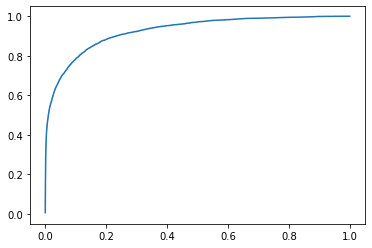

Area under roc 0.9254216274365361


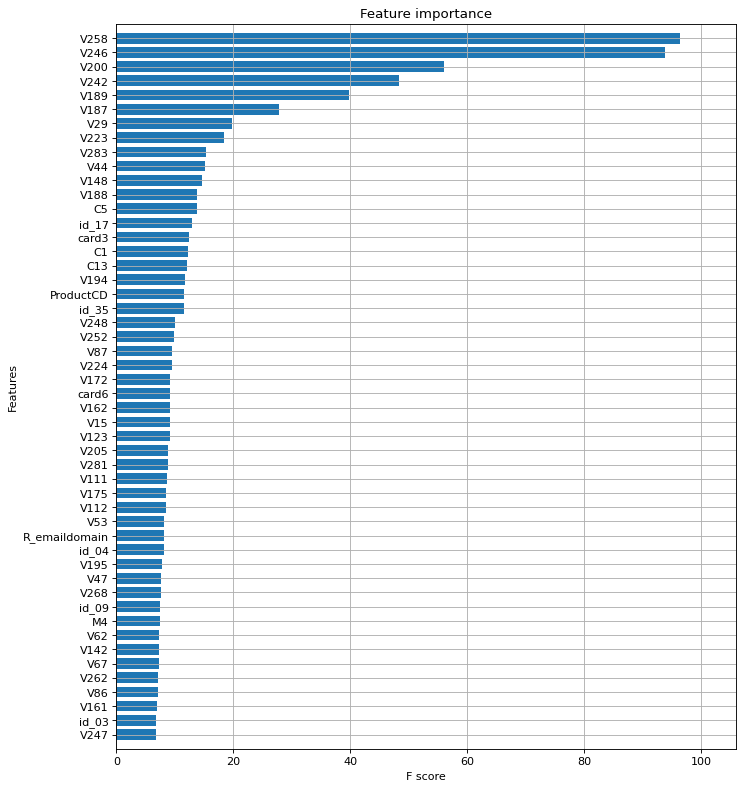

0.9254216274365361

In [64]:
xg_boost(x_train, y_train, x_test, y_test)